# Libraries Import


In [ ]:
#We Import our libraries First
import numpy as np #To get the numeric python library for info
import pandas as pd #To be able to work with Panda Arrays
import matplotlib.pyplot as plt #To plot our images
import seaborn as sns #Plotting library based on Matplotlib to get better customizable graphs

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn import svm #Importing Classification model "Support Vector Machine"
from sklearn.tree import DecisionTreeClassifier #Importing Classification model "DecisionTreeClassifier"
from sklearn.ensemble import RandomForestClassifier #Importing Classification model "RandomForestsClassifier"

#From SciKit-Learn we import how to split the traning and split data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import tensorflow as tf
print("\nTensorflow version " + tf.__version__)


#To do transformation with layers in tensorflow
from tensorflow.keras import layers, Model, Input


#We import a package to evaluate missing Nulls Visually
import missingno as msno

#Import copy utility
import shutil

#import os to manage paths and dir creation
import os
import sys

#For deep learning we import the following packages
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from keras import applications
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img, smart_resize, save_img
from keras import optimizers
from keras.models import Sequential

# Step 0: Create Paths and Folders for **Process**

In [2]:
# Declare Sub-Directories Paths
dataFolder = r'train2020/' # 33126 images of ISIC2020 for training (Many could be classified as unknown)
augFolder = r'augmented/' # Path to augmentation Data
isic2017testFolder = r'testISIC2017/'
finalTrainFolder = r'finaltrain/' # Path to Filtered Train
classifiedTrain = r'classifiedTrain/' # Final Processed Images for Train
classifiedTest = r'classifiedTest/' # Final Processed Images for Test

#Name of CSV files
dataCSV2017 = 'ISIC2017GroundTruth.csv' # CSV with details of each image
dataCSV = 'ISIC_2020_Training_GroundTruth_v2.csv' # CSV with details of each image (Dataset V2)

#Import CSV into Pandas Dataframe
dfCSV = pd.read_csv(dataCSV)
dfCSV2017 = pd.read_csv(dataCSV2017)


#Define A few constants
numAugmented = 10
resizeVector = (224,224)
testSize = 0.2 # Percentage of Test Set
forzarBalance = 1
#0 To do augmnetation with Augmentation Index
#1 To force balance while removing the highest class and then agument based on weights
#2 To not do augmentation



***Create finalTrainFolder***

In [3]:
#Create output directory for final training Files
try:
    if not os.path.exists(finalTrainFolder):
        os.makedirs(finalTrainFolder)
        print("Creating folder: ",finalTrainFolder)
    else:
        shutil.rmtree(finalTrainFolder)
        os.makedirs(finalTrainFolder)
        print("Creating folder: ",finalTrainFolder)
except OSError:
        sys.exit('Fatal: output directory ' + finalTrainFolder +' does not exist and cannot be created')

Creating folder:  finaltrain/


***Create augFolder + classifiedTrain + classifiedTest (Not neccesary to run everytime)*** 

In [4]:
#If folder doesnt exist, it creates it, if it does it deletes it and then creates it
try:
    if not os.path.exists(augFolder):
        os.makedirs(augFolder)
        print("Creating folder: ",augFolder)
    else:
        shutil.rmtree(augFolder)
        os.makedirs(augFolder)
        print("Creating folder: ",augFolder)
except OSError:
        sys.exit('Fatal: output directory ' + augFolder +' does not exist and cannot be created')



#Crea directorio para imagenes de austin y Luis para que puedan trabajar
try:
    if not os.path.exists(classifiedTrain):
        os.makedirs(classifiedTrain)
        print("Creating folder: ",classifiedTrain)
    else:
        shutil.rmtree(classifiedTrain)
        os.makedirs(classifiedTrain)
        print("Creating folder: ",classifiedTrain)
except OSError:
        sys.exit('Fatal: output directory ' + classifiedTrain +' does not exist and cannot be created')

#Crea directorio para imagenes de austin y Luis para que puedan trabajar
try:
    if not os.path.exists(classifiedTest):
        os.makedirs(classifiedTest)
        print("Creating folder: ",classifiedTest)
    else:
        shutil.rmtree(classifiedTest)
        os.makedirs(classifiedTest)
        print("Creating folder: ",classifiedTest)
except OSError:
        sys.exit('Fatal: output directory ' + classifiedTest +' does not exist and cannot be created')



Creating folder:  augmented/
Creating folder:  classifiedTrain/
Creating folder:  classifiedTest/


# Step 1: Data will be Plotted to undestand the distribution of it

In [5]:
#We get the available classes and Labels
print("Classes Available:\n %s" % (dfCSV.columns))
#We print first 10 rows of the data to visualize it and have a better sense of what we are dealing with
dfCSV.sample(10)

Classes Available:
 Index(['image_name', 'patient_id', 'lesion_id', 'sex', 'age_approx',
       'anatom_site_general_challenge', 'diagnosis', 'benign_malignant',
       'target', 'asymmetry'],
      dtype='object')


,image_name,patient_id,lesion_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,asymmetry
30421,ISIC_9191261,IP_3714517,IL_3529546,male,40.0,torso,nevus,benign,0,0
13477,ISIC_4136832,IP_6894159,IL_6600883,female,65.0,torso,unknown,benign,0,0
22964,ISIC_6977097,IP_9115451,IL_1538126,male,65.0,lower extremity,unknown,benign,0,0
10615,ISIC_3276395,IP_9898991,IL_2302061,female,50.0,upper extremity,unknown,benign,0,0
17548,ISIC_5357160,IP_8027787,IL_4795801,male,75.0,NaN,unknown,benign,0,0
28714,ISIC_8686847,IP_3293726,IL_6094269,male,80.0,torso,nevus,benign,0,0
8633,ISIC_2688084,IP_3298186,IL_4740266,female,70.0,torso,unknown,benign,0,0
224,ISIC_0185177,IP_7132179,IL_8827061,male,40.0,lower extremity,nevus,benign,0,0
29397,ISIC_8887405,IP_2153088,IL_8205349,female,30.0,lower extremity,unknown,benign,0,0
6346,ISIC_1991332,IP_9427625,IL_0840151,male,20.0,upper extremity,unknown,benign,0,0


Rows with Null values will be removed as it will be interpreted as corrupted data



The total number of Images (Rows) is: 33126
The number of Null Values per Label is:

image_name                         0
patient_id                         0
lesion_id                          0
sex                               65
age_approx                        68
anatom_site_general_challenge    527
diagnosis                          0
benign_malignant                   0
target                             0
asymmetry                          0
dtype: int64


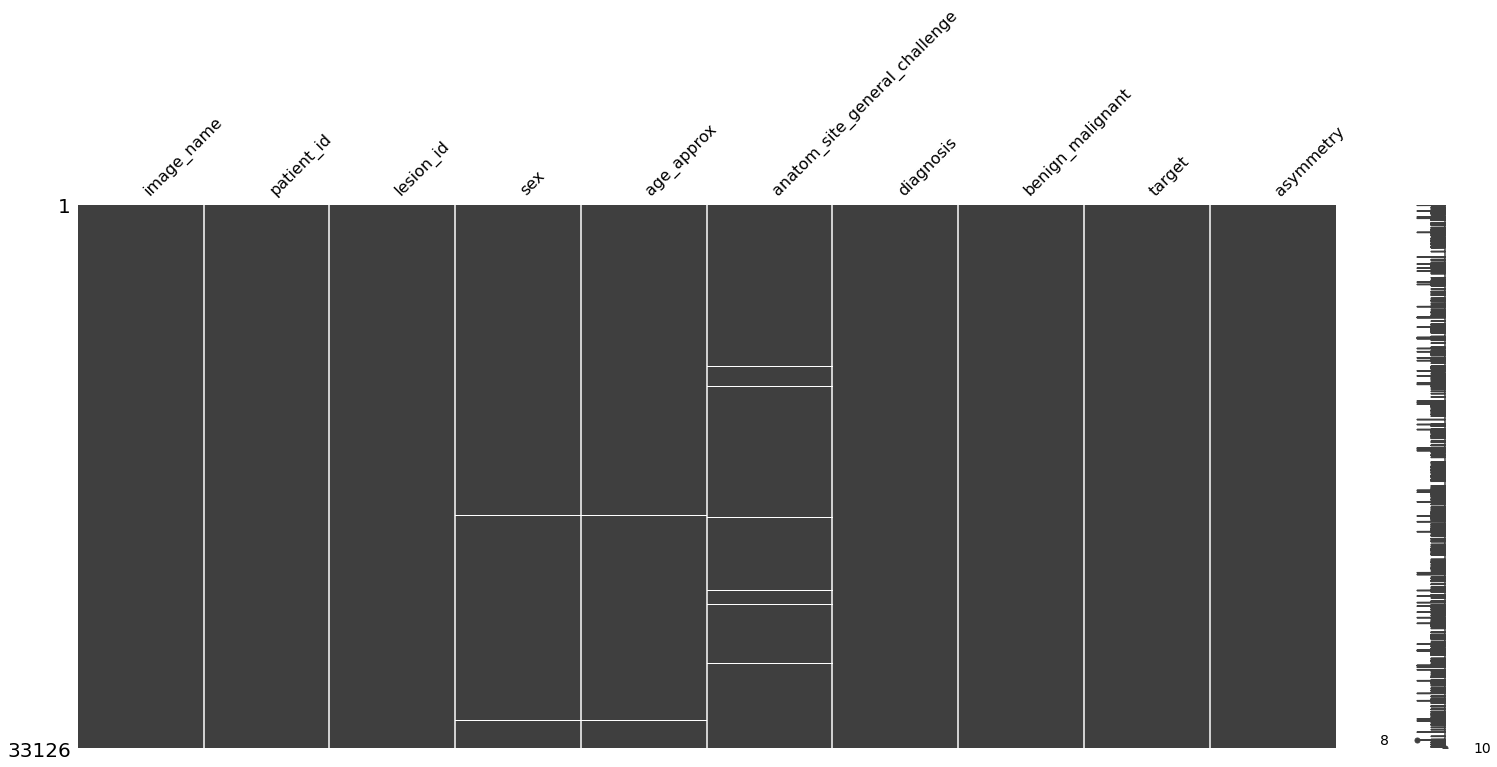

In [6]:
print("The total number of Images (Rows) is: %s" % (dfCSV.shape[0],))
print("The number of Null Values per Label is:\n")
print(dfCSV.isnull().sum())
nullGrafico = msno.matrix(dfCSV)

Since we have NULL values we have a couple of options to handle this:
1. Delete those entries in out dataframe
2. Only use them for DL
3. Input it into LightGBM ("Light Gradient Boosting Machine") because will ignore missing values during a split, then allocate them to whichever side reduces the loss the most 
4. Input it into the model XGBoost "Extreme Gradient Boostin") because for the null values the instance is classified into a default direction (the optimal default directions are learnt from the data somehow)

We decide to remove them as option 1)

In [7]:
#Drop values of the current data set
dfCSV = dfCSV.dropna(axis=0, how = 'any')
print("The total number of Rows without NULLs is: %s" % (dfCSV.shape,))
rowsRemoved = dfCSV.shape[0]-dfCSV.shape[0]
print("Rows removed due to NULL Values: %i"%(rowsRemoved))
dfCSV.isnull().sum()

The total number of Rows without NULLs is: (32531, 10)
Rows removed due to NULL Values: 0


image_name                       0
patient_id                       0
lesion_id                        0
sex                              0
age_approx                       0
anatom_site_general_challenge    0
diagnosis                        0
benign_malignant                 0
target                           0
asymmetry                        0
dtype: int64

We then plot to see the distribution of the dataset

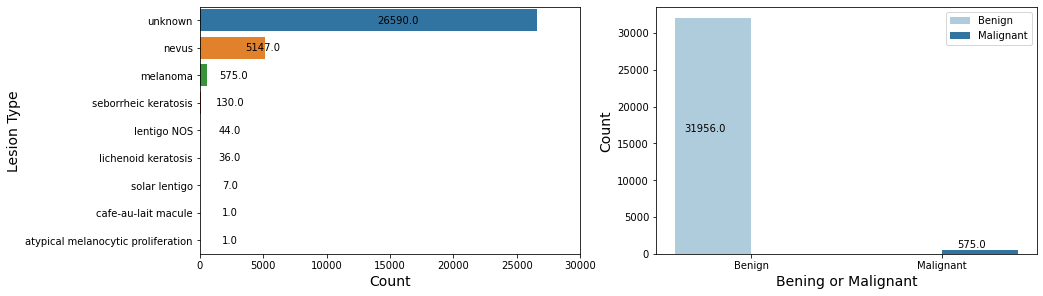

In [8]:
#We define the size in inches width and height for the figure where we'll plot Information
fig = plt.figure(figsize=(15,10)) #Width,Height
#We add the plotting figures inside the object fig
fig1 = fig.add_subplot(221)
fig2 = fig.add_subplot(222)
#fig3 = fig.add_subplot(223)
#fig4 = fig.add_subplot(224)

#####FIGURE 1#####
#We'll use sns to make it beautiful
grafica = sns.barplot(x=dfCSV['diagnosis'].value_counts(),y=dfCSV['diagnosis'].unique(),palette=sns.color_palette("tab10"),ax=fig1)
for p in grafica.patches:
    #First parameter value to plot as annotation, second parameter the coordinate
    #p.get_width gets the value of the thing and p.get_y the location vertically
    grafica.annotate(p.get_width(), (p.get_width()/2., p.get_y()+p.get_height()/2.), 
                   ha = 'center', va = 'center', 
                   xytext = (30, 0), #Offset in the X and Y Direction
                   textcoords = 'offset points')
fig1.set_xlabel("Count",fontsize=14)
fig1.set_ylabel("Lesion Type",fontsize=14)
fig1.set_xlim([0,30000])

#####FIGURE 2#####
countPlot = sns.countplot(x = 'target', data = dfCSV, hue = 'target',ax=fig2,palette=sns.color_palette("Paired", 2))
for p in countPlot.patches:
  ancho = p.get_xy()
  countPlot.annotate(p.get_height(), (ancho[0],1000 + p.get_height()/2.), 
                   ha = 'center', va = 'center', 
                   xytext = (30, 0), #Offset in the X and Y Direction
                   textcoords = 'offset points')
fig2.legend(["Benign","Malignant"])
fig2.set_xlabel("Bening or Malignant",fontsize=14)
fig2.set_ylabel("Count",fontsize=14)
fig2.set(xticklabels=["Benign","Malignant"])
#####FIGURE 3#####
#sns.histplot(data=dfCSV['age_approx'],kde=True, color='green',ax=fig3)
#fig3.set_xlabel("Age",fontsize=14)
#fig3.set_ylabel("Count",fontsize=14)


#Save plot as PDF in local directory of Google Colan (not Drive)
fig.savefig('Initial-Data-Distribution.pdf',bbox_inches='tight')


## **Step 2: Data Refinement**

We clearly see that the data is super skewed for the types of lesion. Meaning that the Unknown will have to be removed as it does not represent anything for us. This is clearly going to reduce the data set a lot because we don't know what it is.

In [9]:
#We remove all the rows with the diagnosis as 'unknown
dfCSVMod = dfCSV[dfCSV.diagnosis != 'unknown']
rowsRemoved = dfCSV.shape[0]-dfCSVMod.shape[0]
print("Rows removed due to Diagnosis Unknown Values: %i"%(rowsRemoved))

#Checking we only have unique values in image values
unique, counts = np.unique(dfCSVMod['image_name'], return_counts=True)
print("Remaining Unique Values After Removing Unknown: ",sum(counts))


Rows removed due to Diagnosis Unknown Values: 26590
Remaining Unique Values After Removing Unknown:  5941


We got 5,941 images which is a lot less with what we started with. Still, there are a couple of interesting observations:
1. Theres a ration of 1:10 for the malignant vs benign data
2. Three lesions don't have enought information to be considered and shall be removed
    - Solar Lentio
    - Cafe-au-lait macule
    - Atypical melanocytic proliferation
3. Binary classification is possible but we need to do something with the data imbalance
4. For Multicalss classification we could work with the data without change as ponderations could be done (not part of the scope of this exercise)

In [10]:
#We remove all the rows with the three non important lessions
dfCSVMod = dfCSVMod[dfCSVMod.diagnosis != 'solar lentigo']
dfCSVMod = dfCSVMod[dfCSVMod.diagnosis != 'cafe-au-lait macule']
dfCSVMod = dfCSVMod[dfCSVMod.diagnosis != 'atypical melanocytic proliferation']

print("Remaining Rows after Removing non Important Lesions: ",dfCSVMod.shape[0])

Remaining Rows after Removing non Important Lesions:  5932


**Alternative 1:** Force data balance while decreasing the total number of Nevus so that the total number of Benign and Malignant is the same. After this the proportions will be increased with augmentation in a same proportion for every class.

In [12]:
#Count the number of malignant (melanoma), benign and nevus
numberMalignant = np.count_nonzero(dfCSVMod['diagnosis'] == "melanoma")
numberBenignNoNevus = np.count_nonzero(dfCSVMod['diagnosis'] == "seborrheic keratosis")\
    + np.count_nonzero(dfCSVMod['diagnosis'] == "lentigo NOS") + np.count_nonzero(dfCSVMod['diagnosis'] == "lichenoid keratosis")
numberNevus = np.count_nonzero(dfCSVMod['diagnosis'] == "nevus")
numberBenign = numberBenignNoNevus + numberNevus
print("Number malignant: %i"%(numberMalignant))
print("Number Benign No Nevus: %i"%(numberBenignNoNevus))
print("Number Nevus: %i"%(numberNevus))
print("Number Benign: %i"%(numberBenign))

print("Total Lesions: ",dfCSVMod.shape[0])

Number malignant: 575
Number Benign No Nevus: 210
Number Nevus: 5147
Number Benign: 5357
Total Lesions:  5932


Values of Nevus are deleted

In [13]:

if forzarBalance == 1:
    #Generamos lsita aleatoria
    numNecesarios = numberBenign-numberMalignant

    #We'll drop the rows using the index range randomly selected
    for i in range(1,numNecesarios+1): #Hay que agregar 1 o nos quedamos cortos
        print("Numero de Nevus: ",np.count_nonzero(dfCSVMod['diagnosis'] == "nevus"))
        indiceEliminar = dfCSVMod[dfCSVMod.diagnosis == 'nevus'].index
        indiceElegido = np.random.choice(indiceEliminar,1,replace=False)[0]
        print(indiceElegido)
        dfCSVMod.drop(indiceElegido,inplace=True) #Hay que agregar inplace o no se actualiza
        
    print("size after the thing with dfCSV: ",dfCSVMod.shape)
    numberMalignant = np.count_nonzero(dfCSVMod['diagnosis'] == "melanoma")
    numberBenignNoNevus = np.count_nonzero(dfCSVMod['diagnosis'] == "seborrheic keratosis")\
        + np.count_nonzero(dfCSVMod['diagnosis'] == "lentigo NOS") + np.count_nonzero(dfCSVMod['diagnosis'] == "lichenoid keratosis")
    numberNevus = np.count_nonzero(dfCSVMod['diagnosis'] == "nevus")
    numberBenign = numberBenignNoNevus + numberNevus
    print("Number malignant: %i"%(numberMalignant))
    print("Number Benign No Nevus: %i"%(numberBenignNoNevus))
    print("Number Nevus: %i"%(numberNevus))
    print("Number Benign: %i"%(numberBenign))



Numero de Nevus:  5147
2767
Numero de Nevus:  5146
3747
Numero de Nevus:  5145
516
Numero de Nevus:  5144
2004
Numero de Nevus:  5143
5137
Numero de Nevus:  5142
388
Numero de Nevus:  5141
5087
Numero de Nevus:  5140
4729
Numero de Nevus:  5139
2474
Numero de Nevus:  5138
1789
Numero de Nevus:  5137
5138
Numero de Nevus:  5136
1585
Numero de Nevus:  5135
91
Numero de Nevus:  5134
5660
Numero de Nevus:  5133
4422
Numero de Nevus:  5132
4657
Numero de Nevus:  5131
5388
Numero de Nevus:  5130
281
Numero de Nevus:  5129
5577
Numero de Nevus:  5128
352
Numero de Nevus:  5127
812
Numero de Nevus:  5126
289
Numero de Nevus:  5125
4828
Numero de Nevus:  5124
3136
Numero de Nevus:  5123
2548
Numero de Nevus:  5122
1726
Numero de Nevus:  5121
2270
Numero de Nevus:  5120
4524
Numero de Nevus:  5119
5317
Numero de Nevus:  5118
5474
Numero de Nevus:  5117
4992
Numero de Nevus:  5116
1126
Numero de Nevus:  5115
5724
Numero de Nevus:  5114
2277
Numero de Nevus:  5113
2475
Numero de Nevus:  5112
3386


Because we don't have a lot of images we will use data agumentation to generate more images then populate the dataset and increase the variance for training. This is done through small alterations in the images that will help to create a more robust model while reducen skewness.

We'll also use normalization to ensure every pixel of all our images are at the same scale. Normalize an image with mean and standard deviation. This wil (according to Keras documentation) will coerce its inputs into a distribution centered around 0 with standard deviation 1. It accomplishes this by precomputing the mean and variance of the data, and calling (input - mean) / sqrt(var) at runtime

According to keras.io 
In Keras this can be done via the keras.preprocessing.image.ImageDataGenerator class. This class allows you to:

1. configure random transformations and normalization operations to be done on your image data during training
2. instantiate generators of augmented image batch

We'll create an oject of this class using the following transformations:

In [14]:
#We create the object containing the attributes selected

trainDatagen = ImageDataGenerator( #To do a simple normalization we would do featurewise_std_normalization=True
        rotation_range=40, #Usually people select 60 degrees for some reason
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        rescale=1./255,
        #shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True, #Sometimes only used for training data, not test data
        #fill_mode='nearest',
        samplewise_center=True)

testDatagen = ImageDataGenerator( #Los tests van sin tantas modificaicones de augmented
        rescale=1./255,
        zoom_range=0.2,
        rotation_range=40)


#We'll create the function to normalize
promedio = [0.485, 0.456, 0.406]
estandar = [0.229, 0.224, 0.225]

def myNormalize(image_data): #output[channel] = (inputImage[channel] - mean[channel]) / std[channel]
        image_data = image_data/255.0 #To adjust to a 1 as maximum value
        image_data[:,:,0] = (image_data[:,:,0] - promedio[0])/estandar[0]
        image_data[:,:,1] = (image_data[:,:,1] - promedio[1])/estandar[1]
        image_data[:,:,2] = (image_data[:,:,2] - promedio[2])/estandar[2]
        return image_data


Before creating the augmentation we'll calculate the weights for each class

In [15]:
le = LabelEncoder() #Label encoder is a function from "sklearn"
le.fit(dfCSVMod['diagnosis']) #Inputs the data in the dx column
LabelEncoder() #LabelEncoder is executed and transforms de data (single occurance)

label = le.classes_ #It works too :)
metadata = dfCSVMod
#Define the function for Median Frequency Balancing (MFB)
def estimate_weights_mfb(label):
    class_weights = np.zeros_like(label, dtype=float)
    counts = np.zeros_like(label)
    for i,l in enumerate(label):
        counts[i] = metadata[metadata['diagnosis']==str(l)]['diagnosis'].value_counts()[0] #We use the frequency of the labels in the metadata-frame
    counts = counts.astype(float)
    median_freq = np.median(counts)
    for i, label in enumerate(label):
        class_weights[i] = median_freq / counts[i]
    return class_weights #returns list with weighted values

classweight= estimate_weights_mfb(label)
for i in range(len(label)):
    print(label[i],":", classweight[i])

lentigo NOS : 2.9545454545454546
lichenoid keratosis : 3.611111111111111
melanoma : 0.22608695652173913
nevus : 0.3561643835616438
seborrheic keratosis : 1.0


After the transformations and weights are created we need to augmentate the data for each image

If it is decided to force the balanced before, the augmentation will be equal for all clases, if no balanced force, the augmentation will be done according to the ponderations

In [16]:
##Data Augmentation
porAugmentar = 0

#Iter through each file in the dfCSVMod dataset and create its corresponding agumentation images. numAugmented defiens the # of images
for idx,row in dfCSVMod.iterrows():
    i = 0
    img = load_img(dataFolder + row[0] + '.jpg')
    imgArray = img_to_array(img) # this is a Numpy array with shape (pixels width,pixels height,3 for RGB)
    imgArray.astype('float32')/255
    imgArray = smart_resize(imgArray,resizeVector,interpolation='bilinear')
    #The following lines adds 1 lined to make it a 4D matrix because numpy array iterator requires this
    imgArray = imgArray.reshape((1,) + imgArray.shape)  # this is a Numpy array with shape (1, pixels width,pixels height,3 for RGB)
    
    if forzarBalance == 1: #We remove rows from Nevus
        porAugmentar = int(round(numAugmented));

    elif forzarBalance == 0: #WE dont remove rows from nevus, we just augment the other ones
        if row[6] == 'lentigo NOS':
            weightC = classweight[0]
        elif  row[6] == 'lichenoid keratosis':
            weightC = classweight[1]
        elif  row[6] == 'melanoma':
            weightC = classweight[2]
        elif  row[6] == 'nevus':
            weightC = classweight[3]
        elif  row[6] == 'seborrheic keratosis':
            weightC = classweight[4]
        porAugmentar = int(round(numAugmented*weightC));

    elif forzarBalance == 2: #No augmentation is done
        weightC = 0.0
        porAugmentar = int(round(numAugmented*weightC));
        
    print("Augmenting data for: %s"%(row[0]))
    if porAugmentar !=0:

        #We create the number of numAgumented data images per each one of the original images. In Our case 1151*NumAgumented
        for batch in trainDatagen.flow(imgArray, batch_size=1, #batch size is the number of samples one passes
                                save_to_dir=augFolder, save_prefix=row[0], save_format='jpg',):
            i += 1
         
            if i >= porAugmentar: #Breaks when the number of augmentations per file has been created
                break  # otherwise the generator would loop indefinitely


    

Augmenting data for: ISIC_0149568
Augmenting data for: ISIC_0171983
Augmenting data for: ISIC_0188432
Augmenting data for: ISIC_0203016
Augmenting data for: ISIC_0207268
Augmenting data for: ISIC_0217267
Augmenting data for: ISIC_0224678
Augmenting data for: ISIC_0232101
Augmenting data for: ISIC_0238491
Augmenting data for: ISIC_0247330
Augmenting data for: ISIC_0250839
Augmenting data for: ISIC_0263178
Augmenting data for: ISIC_0272509
Augmenting data for: ISIC_0273046
Augmenting data for: ISIC_0274382
Augmenting data for: ISIC_0275828
Augmenting data for: ISIC_0280912
Augmenting data for: ISIC_0286360
Augmenting data for: ISIC_0327406
Augmenting data for: ISIC_0333091
Augmenting data for: ISIC_0333589
Augmenting data for: ISIC_0337631
Augmenting data for: ISIC_0351666
Augmenting data for: ISIC_0369831
Augmenting data for: ISIC_0381169
Augmenting data for: ISIC_0383804
Augmenting data for: ISIC_0420477
Augmenting data for: ISIC_0433569
Augmenting data for: ISIC_0437593
Augmenting dat

Nowe we have agumentated data but we should resize the original images from which the augmentated images were obtained; aswell as normalizing and putting it in the finalTrainFolder. This will help us have all the images in the same folder ready from training (Original resized + Augmentated)

In [17]:
###In the mean time we need to move the Not agumentaded images to the finalTrainFolder

### We iterate over the mod file to get th ename of the picture, mix with the file name and then we save it
# into the finalTrainFolder

for idx,row in dfCSVMod.iterrows():
    img = load_img(dataFolder + row[0] + '.jpg')
    imgArray = img_to_array(img) # this is a Numpy array with shape (pixels width,pixels height,3 for RGB)
    #imgArray = myNormalize(imgArray) #We normalize using the imagenet standard values in the defined function above
    imgArray.astype('float32')/255
    imgArray = smart_resize(imgArray,resizeVector,interpolation='bilinear')
    save_img(finalTrainFolder+ row[0] + '.jpg',imgArray)

The filenames and ground truth of the augmented images should be included in the dfCVSMod (cleaned original Dataframe). Becase this data is based on an image, the labels (other than the name) will be the same. We'll store this big dataset in what we call **dfAug**.

In [18]:
#We create a new dataset with the augmented data
dfAugmented = dfCSVMod;
existingRows = dfAugmented.shape[0] #Actualmente tenemos 5941 filas queremos agregar los files existentes
#List of files in the directory
listFiles = os.listdir(augFolder)
contador = 0;
for archivo in listFiles:
    archivoCorregido = archivo[:-4]
    #We recover the original file name from the augmetned files
    splitName = archivo.split("_",2)
    joinName = "_".join(splitName[:2])
    #We extract the existing data of the image row in the data set. We'll copy everything except from the filename to the augmented pictures that came
    #from it
    tempRow = dfAugmented.loc[dfAugmented['image_name'] == joinName]
    #This is the temporal row to append, only changing the image name with the augmented data  and keeping the rest the same
    new_row = {tempRow.columns[0]:archivoCorregido,\
        tempRow.columns[1]:tempRow.iloc[0]['patient_id'],\
        tempRow.columns[2]:tempRow.iloc[0]['lesion_id'],\
        tempRow.columns[3]:tempRow.iloc[0]['sex'],\
        tempRow.columns[4]:tempRow.iloc[0]['age_approx'],\
        tempRow.columns[5]:tempRow.iloc[0]['anatom_site_general_challenge'],\
        tempRow.columns[6]:tempRow.iloc[0]['diagnosis'],\
        tempRow.columns[7]:tempRow.iloc[0]['benign_malignant'],\
        tempRow.columns[8]:tempRow.iloc[0]['target'],\
        tempRow.columns[9]:tempRow.iloc[0]['asymmetry'],\
                }
    #append row to the dataframe
    dfAugmented = dfAugmented.append(new_row, ignore_index=True)
    contador+=1


We will put the augmentated images withe the original resized images to have everything in the same folder.

In [19]:
#We move augmentation images to a finaltrainfolder
listFiles = os.listdir(augFolder)
for archivo in listFiles:
        original = augFolder + archivo
        target = finalTrainFolder + archivo
        shutil.copyfile(original, target)

We plot to see how is the distribution now with augmented and the original data

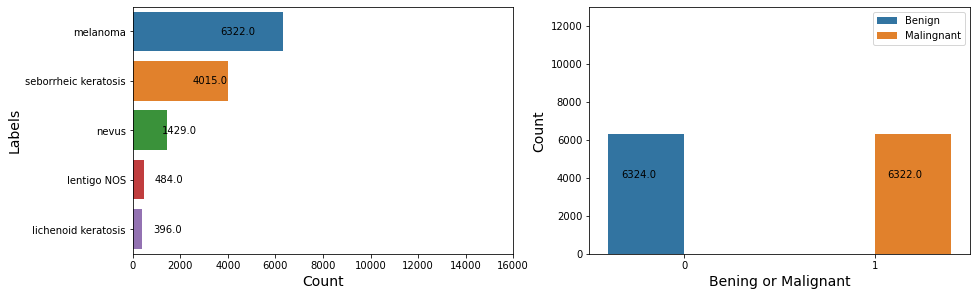

In [20]:
#We define the size in inches width and height for the figure where we'll plot Information
figura = plt.figure(figsize=(15,10)) #Width,Height
#We add the plotting figures inside the object fig
fig1 = figura.add_subplot(221)
fig2 = figura.add_subplot(222)


#####FIGURE 1#####
#We'll use sns to make it beautiful
grafica = sns.barplot(x=dfAugmented['diagnosis'].value_counts(),y=dfAugmented['diagnosis'].unique(),palette="tab10",ax=fig1)
for p in grafica.patches:
    #First parameter value to plot as annotation, second parameter the coordinate
    #p.get_width gets the value of the thing and p.get_y the location vertically
    grafica.annotate(p.get_width(), (p.get_width()/2., p.get_y()+p.get_height()/2.), 
                   ha = 'center', va = 'center', 
                   xytext = (30, 0), #Offset in the X and Y Direction
                   textcoords = 'offset points')
fig1.set_xlabel("Count",fontsize=14)
fig1.set_ylabel("Labels",fontsize=14)
fig1.set_xlim([0,16000])

#####FIGURE 2#####
countPlot = sns.countplot(x = 'target', data = dfAugmented, hue = 'target',ax=fig2)
for p in countPlot.patches:
  ancho = p.get_xy()
  countPlot.annotate(p.get_height(), (ancho[0],1000 + p.get_height()/2.), 
                   ha = 'center', va = 'center', 
                   xytext = (30, 0), #Offset in the X and Y Direction
                   textcoords = 'offset points')
fig2.legend(["Benign","Malingnant"])
fig2.set_xlabel("Bening or Malignant",fontsize=14)
fig2.set_ylabel("Count",fontsize=14)
fig2.set_ylim([0,13000])

#Save plot as PDF
figura.savefig('AfterAugmenting.pdf',bbox_inches='tight') #


After having all of our images in one place and a correct data set labeled we can continue with training
We should create the Train and Test Splits (using scikit-learn). We'll define the Test size as 20% of the entire data (common value)

This is one key step, we define what labels we'll use for it. We'll do 2 things at the same time:
1. Keep working with our dfAugmented data as it is
2. Create dummies values and understand linearity and which variables are the best

In [21]:
#Remember that our mixed dataset is called dfAugmented
print(dfAugmented.columns)
print(dfAugmented.shape)

#Let's create dummie dataframe
dfDummies = dfAugmented

#We start creating Dummie while changing the properties
dfDummies = pd.get_dummies(dfDummies, columns = ['sex'],drop_first=False) #We don't delete one of the columns (this could impact corelation)
dfDummies = pd.get_dummies(dfDummies, columns = ['anatom_site_general_challenge'],drop_first=False)
dfDummies = pd.get_dummies(dfDummies, columns = ['diagnosis'],drop_first=False)
dfDummies = pd.get_dummies(dfDummies, columns = ['benign_malignant'],drop_first=False)

#We'll drop the columns "patient_id" and "lesion_id" because they represent nothing to us
dfDummies = dfDummies.drop(['patient_id','lesion_id'], axis = 1)
dfDummies.head()



Index(['image_name', 'patient_id', 'lesion_id', 'sex', 'age_approx',
       'anatom_site_general_challenge', 'diagnosis', 'benign_malignant',
       'target', 'asymmetry'],
      dtype='object')
(12646, 10)


,image_name,age_approx,target,asymmetry,sex_female,sex_male,anatom_site_general_challenge_head/neck,anatom_site_general_challenge_lower extremity,anatom_site_general_challenge_oral/genital,anatom_site_general_challenge_palms/soles,anatom_site_general_challenge_torso,anatom_site_general_challenge_upper extremity,diagnosis_lentigo NOS,diagnosis_lichenoid keratosis,diagnosis_melanoma,diagnosis_nevus,diagnosis_seborrheic keratosis,benign_malignant_benign,benign_malignant_malignant
0,ISIC_0149568,55,1,0.425113,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1
1,ISIC_0171983,70,0,0.108337,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0
2,ISIC_0188432,50,1,0.194424,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1
3,ISIC_0203016,55,0,0.127706,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0
4,ISIC_0207268,55,1,0.084404,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1


We need to determine the relation between our new dummies columns to select the best parameters to drop or keep

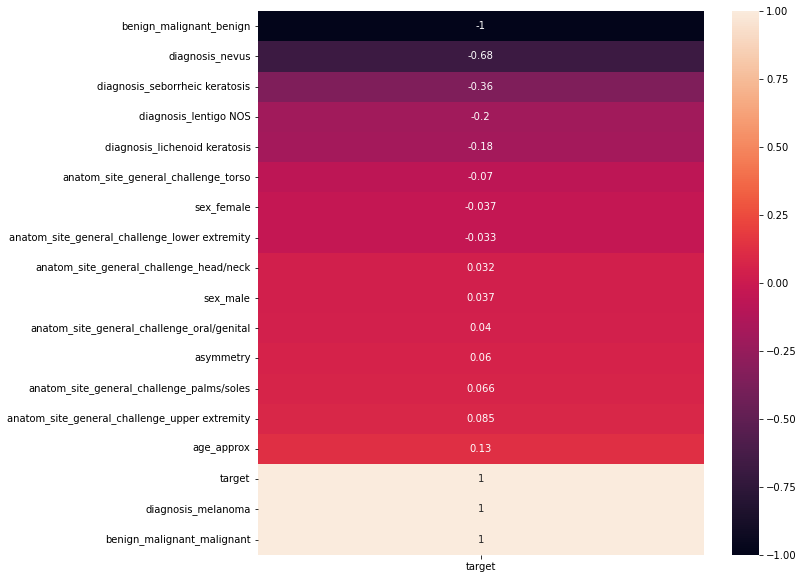

In [22]:
plt.figure(figsize = (10,10))
sns.heatmap(dfDummies.corr()[['target']].sort_values('target'), annot = True) #Output is the  "target", we sort it by correlation

#Save plot as PDF
plt.savefig('dataCorrelation.pdf',bbox_inches='tight')

We can observe that the relation to labels like "benign_malignant_malignant" and "benign_malignant_benign" is directly related to Target, therefore we would have to drop those two columns to ensure no colinearity that affects the result is detected. We'll leave the diagnosis.

We'll select the variables with higher correlation to the output target (positives and negatives) (we'll use this at the end of the code for function fitting based on labels)

In the mean time lests create the training and test sets for image classification.

In [23]:
#We Select the labels that we'll use, we should include the 'image_size' to access it BEFORE TRAINING BUT NOT INCLUDE IT TO TRAIN
X = dfDummies['image_name']
Y = dfDummies['target']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = testSize, random_state = 1)

Before moving forward we'll create folders for training and test with the classified folders using the split above

In [24]:

# A path to the folder which has all the images that we want to copy somewhere else
data_dir = finalTrainFolder

# A path to the folder where you want to store the rearranged images:
dest_dir = classifiedTrain #Individual folder blk, nv and so on will be created inside the folder will all the images

# Read the metadata file:
label = ['benign', 'malignant']   #1 is melanoma, these could also be numbers but we'll leave it like this
#label_images = []

# Copy the images into new folder structure:
for i in label:
    #os.mkdir(dest_dir + str(i) + "/") #Not working if folder already exists, had to add the try and catch below
    try:
        if not os.path.exists(dest_dir + str(i) + "/"):
            os.makedirs(dest_dir + str(i) + "/")
        print("Creating folder: ",dest_dir, str(i),"/")
    except OSError:
        sys.exit('Fatal: output directory "' + dest_dir + str(i) + "/" + '" does not exist and cannot be created')

    if i == 'benign':
        valueS = 0
    elif i == 'malignant':
        valueS = 1

    sample = X_train.values[Y_train.values == valueS]

    for id in sample:
        shutil.copyfile((data_dir + "/"+ id +".jpg"), (dest_dir + i + "/"+id+".jpg"))

###### LETS REPEAT FOR THE TEST VERSION NOW

# A path to the folder where you want to store the rearranged images:
dest_dir = classifiedTest #Individual folder blk, nv and so on will be created inside the folder will all the images

# Read the metadata file:
label = ['benign', 'malignant']   #1 is melanoma, these could also be numbers but we'll leave it like this

# Copy the images into new folder structure:
for i in label:
    try:
        if not os.path.exists(dest_dir + str(i) + "/"):
            os.makedirs(dest_dir + str(i) + "/")
        print("Creating folder: ",dest_dir, str(i),"/")
    except OSError:
        sys.exit('Fatal: output directory "' + dest_dir + str(i) + "/" + '" does not exist and cannot be created')

    if i == 'benign':
        valueS = 0
    elif i == 'malignant':
        valueS = 1

    sample = X_test.values[Y_test.values == valueS]

    for id in sample:
        shutil.copyfile((data_dir + "/"+ id +".jpg"), (dest_dir + i + "/"+id+".jpg"))

Creating folder:  classifiedTrain/ benign /
Creating folder:  classifiedTrain/ malignant /
Creating folder:  classifiedTest/ benign /
Creating folder:  classifiedTest/ malignant /


Now we got our sets for training and testing X and Y. Let's try RandomForest Algorithm

**Get Training Data ready for classifiers**

In [25]:
#With X_Train let's get the image data into one vector
imagesTrain = []
for i in X_train:
    image = finalTrainFolder + i +'.jpg'
    imagesTrain.append(plt.imread(image).flatten())

#Random Forest Algorithm
xModelTrain = imagesTrain
yModelTrain = Y_train

**Get Test Data ready for Classifiers**

In [26]:
#With X_Test let's get the image data into one vector
imagesTest = []
for i in X_test:
    image = finalTrainFolder + i +'.jpg'
    imagesTest.append(plt.imread(image).flatten())


xModelTest = imagesTest
yModelTest = Y_test

## **RANDOM FORESTS ALGORITHM**

In [27]:
classifier_rf = RandomForestClassifier()
classifier_rf.fit(xModelTrain,yModelTrain)

RandomForestClassifier()

We have our model trained. It's time to test it with the other data not used

In [28]:
y_pred_rf = classifier_rf.predict(xModelTest) #We predict

print('Accuracy Score: ',accuracy_score(yModelTest,y_pred_rf))
print('Confusion Matrix: \n',confusion_matrix(yModelTest,y_pred_rf))

print(classification_report(yModelTest,y_pred_rf,zero_division = 0))
print(classification_report(yModelTest,y_pred_rf,zero_division = 1))


Accuracy Score:  0.8723320158102766
Confusion Matrix: 
 [[1101  184]
 [ 139 1106]]
              precision    recall  f1-score   support

           0       0.89      0.86      0.87      1285
           1       0.86      0.89      0.87      1245

    accuracy                           0.87      2530
   macro avg       0.87      0.87      0.87      2530
weighted avg       0.87      0.87      0.87      2530

              precision    recall  f1-score   support

           0       0.89      0.86      0.87      1285
           1       0.86      0.89      0.87      1245

    accuracy                           0.87      2530
   macro avg       0.87      0.87      0.87      2530
weighted avg       0.87      0.87      0.87      2530



In [29]:
#Confusion MAtrix Beautification
def print_confusion_matrix(confusion_matrix, class_names, fileNombre, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Note that due to returning the created figure object, when this funciton is called in a
    notebook the figure willl be printed twice. To prevent this, either append ; to your
    function call, or modify the function by commenting out the return expression.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #Save plot as PDF
    
    #Save image
    plt.savefig(fileNombre,bbox_inches='tight')

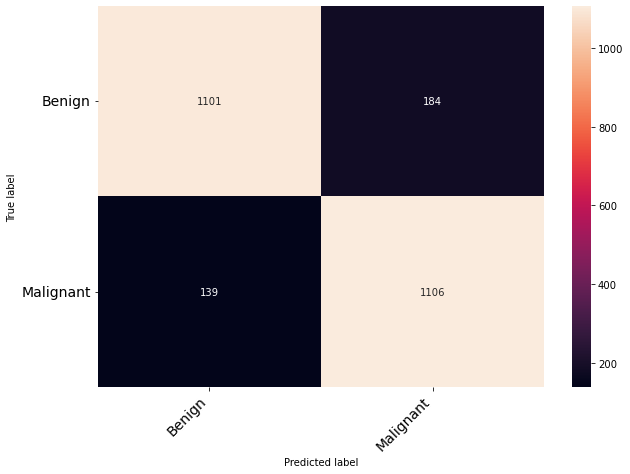

In [30]:
#Beautification call
print_confusion_matrix(confusion_matrix(yModelTest,y_pred_rf),["Benign","Malignant"],'confusionRandomForestsTest.pdf')


## **SUPPORT VECTOR MACHINE**

In [35]:
classifier_svm = svm.SVC()
classifier_svm.fit(xModelTrain,yModelTrain)

y_pred_svm = classifier_svm.predict(xModelTest)
print('Accuracy Score: ',accuracy_score(yModelTest,y_pred_svm))
print('Confusion Matrix: \n',confusion_matrix(yModelTest,y_pred_svm))

print(classification_report(yModelTest,y_pred_svm,zero_division = 0))
print(classification_report(yModelTest,y_pred_svm,zero_division = 1))

Accuracy Score:  0.807905138339921
Confusion Matrix: 
 [[1009  276]
 [ 210 1035]]
              precision    recall  f1-score   support

           0       0.83      0.79      0.81      1285
           1       0.79      0.83      0.81      1245

    accuracy                           0.81      2530
   macro avg       0.81      0.81      0.81      2530
weighted avg       0.81      0.81      0.81      2530

              precision    recall  f1-score   support

           0       0.83      0.79      0.81      1285
           1       0.79      0.83      0.81      1245

    accuracy                           0.81      2530
   macro avg       0.81      0.81      0.81      2530
weighted avg       0.81      0.81      0.81      2530



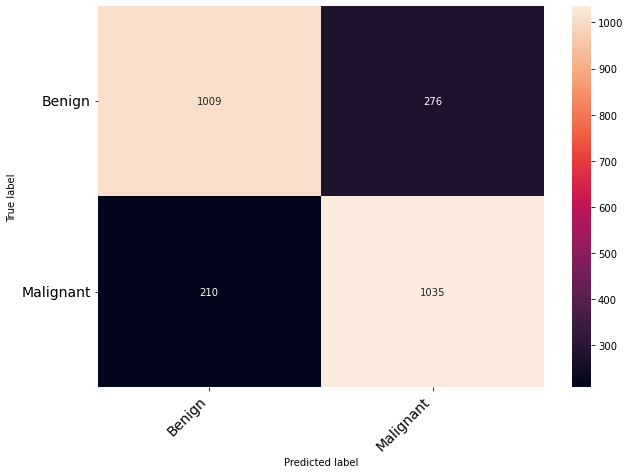

In [36]:
#Beautification call
print_confusion_matrix(confusion_matrix(yModelTest,y_pred_svm),["Benign","Malignant"],'confusionSVMTest.pdf')

## **DECISION TREE**

In [37]:
classifier_dt = DecisionTreeClassifier()
classifier_dt.fit(xModelTrain,yModelTrain)

y_pred_dt = classifier_dt.predict(xModelTest)
print('Accuracy Score: ',accuracy_score(yModelTest,y_pred_dt))
print('Confusion Matrix: \n',confusion_matrix(yModelTest,y_pred_dt))

print(classification_report(yModelTest,y_pred_dt,zero_division = 0))
print(classification_report(yModelTest,y_pred_dt,zero_division = 1))

Accuracy Score:  0.7462450592885376
Confusion Matrix: 
 [[961 324]
 [318 927]]
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      1285
           1       0.74      0.74      0.74      1245

    accuracy                           0.75      2530
   macro avg       0.75      0.75      0.75      2530
weighted avg       0.75      0.75      0.75      2530

              precision    recall  f1-score   support

           0       0.75      0.75      0.75      1285
           1       0.74      0.74      0.74      1245

    accuracy                           0.75      2530
   macro avg       0.75      0.75      0.75      2530
weighted avg       0.75      0.75      0.75      2530



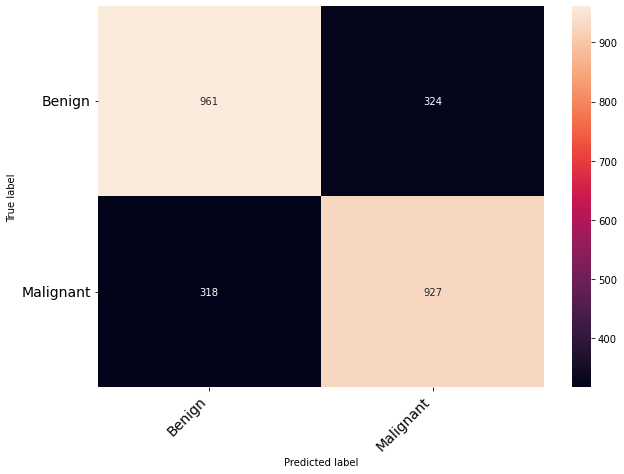

In [38]:
#Beautification call
print_confusion_matrix(confusion_matrix(yModelTest,y_pred_dt),["Benign","Malignant"],'confusionDecisionTreeTest.pdf')

DEEP LEARNING
Since we have few samples, we might see overfitting on specific parameters (Even with augmentation). Because of this we need to "a simple stack of 3 convolution layers with a ReLU activation and followed by max-pooling layers. This is very similar to the architectures that Yann LeCun advocated in the 1990s for image classification (with the exception of ReLU).". 

"On top of it we stick two fully-connected layers. We end the model with a single unit and a sigmoid activation, which is perfect for a binary classification. To go with it we will also use the binary_crossentropy loss to train our model."

In [42]:
# dimensions of our images.
img_width, img_height = 224, 224 
epochs = 50
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])



Let's prepare our data. We will use .flow_from_directory() to generate batches of image data (and their labels) directly from our jpgs in their respective folders.

In [43]:
#El código de abajo sería para hacer data augmentation pero en este caso ya contamos con ello, nos lo saltaremos pero lo dejaremos aqui por motivos de que podrían ayudar en algun otro momento

batch_size = 16 #Este podria ser un cambio necesario para esto

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

## this is the augmentation configuration we will use for testing:
## only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)


## this is a generator that will read pictures found in
## subfolers of 'data/train', and indefinitely generate
## batches of augmented image data
train_generator = train_datagen.flow_from_directory(
    
    classifiedTrain, #train_data_dir, # this is the target directory       #This could also be the training folder
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary') # since we use binary_crossentropy loss, we need binary labels


## this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
    classifiedTest, #We remove the last backslash
    #testFolder, #validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')



Found 10116 images belonging to 2 classes.
Found 2530 images belonging to 2 classes.


We can now use these generators to train our model. Each epoch takes 20-30s on GPU and 300-400s on CPU. So it's definitely viable to run this model on CPU if you aren't in a hurry.

In [44]:
#nb_train_samples = 2000
#nb_validation_samples = 800
nb_train_samples = len(X_train)
nb_validation_samples = len(X_test)

history = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

model.save_weights('neuralWeights.h5') 
model.save('neuralModel.h5')

Epoch 1/50
632/632 [==============================] - 406s 642ms/step - loss: 0.5818 - accuracy: 0.7067 - val_loss: 0.5251 - val_accuracy: 0.7421
Epoch 2/50
632/632 [==============================] - 359s 567ms/step - loss: 0.5262 - accuracy: 0.7485 - val_loss: 0.5049 - val_accuracy: 0.7587
Epoch 3/50
632/632 [==============================] - 400s 633ms/step - loss: 0.5216 - accuracy: 0.7615 - val_loss: 0.6425 - val_accuracy: 0.7164
Epoch 4/50
632/632 [==============================] - 357s 565ms/step - loss: 0.5009 - accuracy: 0.7648 - val_loss: 0.4845 - val_accuracy: 0.7421
Epoch 5/50
632/632 [==============================] - 442s 699ms/step - loss: 0.5009 - accuracy: 0.7609 - val_loss: 0.4497 - val_accuracy: 0.7737
Epoch 6/50
632/632 [==============================] - 379s 600ms/step - loss: 0.4966 - accuracy: 0.7615 - val_loss: 0.5062 - val_accuracy: 0.7492
Epoch 7/50
632/632 [==============================] - 342s 540ms/step - loss: 0.5018 - accuracy: 0.7685 - val_loss: 0.5191 -

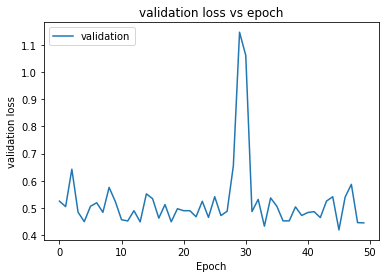

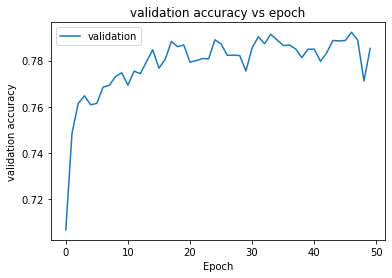

In [45]:
fig = plt.figure()
plt.plot(history.history['val_loss'])
plt.legend(['validation'], loc='upper left')
plt.title('validation loss vs epoch')
plt.ylabel('validation loss')
plt.xlabel('Epoch')

#Save plot as PDF
fig.savefig('neuralLossEpuch.pdf',bbox_inches='tight')

fig = plt.figure()
plt.plot(history.history['accuracy'])
plt.legend(['validation'], loc='upper left')
plt.title('validation accuracy vs epoch')
plt.ylabel('validation accuracy')
plt.xlabel('Epoch')

#Save plot as PDF
fig.savefig('neuralAccEpuch.pdf',bbox_inches='tight')



Bottle Neck NN

Found 10116 images belonging to 2 classes.
Found 2530 images belonging to 2 classes.
Epoch 1/50
633/633 [==============================] - 27s 43ms/step - loss: 0.7007 - accuracy: 0.6561 - val_loss: 0.5063 - val_accuracy: 0.7569
Epoch 2/50
633/633 [==============================] - 28s 44ms/step - loss: 0.5216 - accuracy: 0.7326 - val_loss: 0.6011 - val_accuracy: 0.7024
Epoch 3/50
633/633 [==============================] - 28s 45ms/step - loss: 0.4898 - accuracy: 0.7543 - val_loss: 0.4727 - val_accuracy: 0.7617
Epoch 4/50
633/633 [==============================] - 29s 45ms/step - loss: 0.4737 - accuracy: 0.7661 - val_loss: 0.4453 - val_accuracy: 0.7877
Epoch 5/50
633/633 [==============================] - 27s 43ms/step - loss: 0.4516 - accuracy: 0.7848 - val_loss: 0.4204 - val_accuracy: 0.8051
Epoch 6/50
633/633 [==============================] - 27s 43ms/step - loss: 0.4342 - accuracy: 0.7904 - val_loss: 0.4518 - val_accuracy: 0.7787
Epoch 7/50
633/633 [==============================]

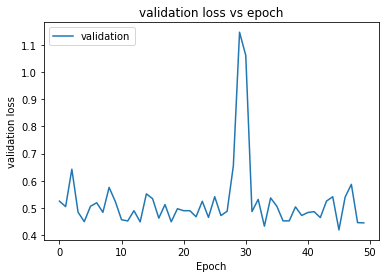

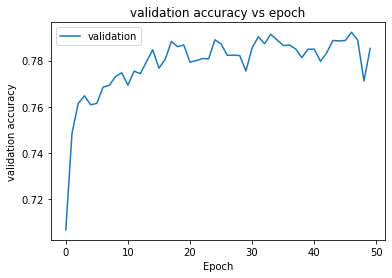

In [46]:
import numpy as np

# dimensions of our images.
#img_width, img_height = 150, 150
img_width, img_height = 224, 224 

top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = classifiedTrain
validation_data_dir = classifiedTest
#nb_train_samples = 2000
#nb_validation_samples = 800
nb_train_samples = len(X_train)
nb_validation_samples = len(X_test)
epochs = 50
batch_size = 16


def save_bottlebeck_features():
    datagen = ImageDataGenerator(rescale=1. / 255)

    # build the VGG16 network
    model = applications.VGG16(include_top=False, weights='imagenet')

    generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    #bottleneck_features_train = model.predict_generator(
    bottleneck_features_train = model.predict(
        generator, nb_train_samples // batch_size)

    with open('bottleneck_features_train.npy', 'wb') as features_train_file:
        np.save(features_train_file, bottleneck_features_train)

    generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)
    #bottleneck_features_validation = model.predict_generator(
    bottleneck_features_validation = model.predict(
        generator, nb_validation_samples // batch_size)

    with open('bottleneck_features_validation.npy', 'wb') as features_validation_file:
        np.save(features_validation_file, bottleneck_features_validation)


def train_top_model():
    with open('bottleneck_features_train.npy', 'rb') as features_train_file:
        train_data = np.load(features_train_file)

    #train_labels = np.array([0] * (nb_train_samples / 2) + [1] * (nb_train_samples / 2))
    train_labels = np.array([0] * (nb_train_samples // 2) + [1] * (nb_train_samples // 2))

    with open('bottleneck_features_validation.npy', 'rb') as features_validation_file:
        validation_data = np.load(features_validation_file)

    #validation_labels = np.array(
    #    [0] * (nb_validation_samples / 2) + [1] * (nb_validation_samples / 2))
    validation_labels = np.array([0] * (nb_validation_samples // 2) + [1] * (nb_validation_samples // 2))

    model = Sequential()
    model.add(Flatten(input_shape=train_data.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy', metrics=['accuracy'])

    hystory = model.fit(train_data, train_labels,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(validation_data, validation_labels))
    model.save_weights(top_model_weights_path)

    fig = plt.figure()
    plt.plot(history.history['val_loss'])
    plt.legend(['validation'], loc='upper left')
    plt.title('validation loss vs epoch')
    plt.ylabel('validation loss')
    plt.xlabel('Epoch')

    #Save plot as PDF
    fig.savefig('neuralBottleLossEpuch.pdf',bbox_inches='tight')

    fig = plt.figure()
    plt.plot(history.history['accuracy'])
    plt.legend(['validation'], loc='upper left')
    plt.title('validation accuracy vs epoch')
    plt.ylabel('validation accuracy')
    plt.xlabel('Epoch')

    #Save plot as PDF
    fig.savefig('neuralBottleAccEpuch.pdf',bbox_inches='tight')


save_bottlebeck_features()
train_top_model()

In [ ]:
#Fine Tunning the NN

# path to the model weights files.
weights_path = 'vgg16_weights.h5'
top_model_weights_path = 'bottleneck_fc_model.h5'    #SAME FILE FROM PREVIOUS RUN
# dimensions of our images.
img_width, img_height = 224, 224 


train_data_dir = classifiedTrain
validation_data_dir = classifiedTest
nb_train_samples = len(X_train)
nb_validation_samples = len(X_test)

epochs = 50
batch_size = 16

laShape = Input(shape=(img_width,img_height,3))

# build the VGG16 network
prev_model = applications.VGG16(weights='imagenet', include_top=False, input_tensor=laShape)
print('Model loaded.')
    

# build a classifier model to put on top of the convolutional model
top_model = Sequential()
top_model.add(Flatten(input_shape=prev_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))


# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
top_model.load_weights(top_model_weights_path)

# add the model on top of the convolutional base
model = Model(inputs=prev_model.input, outputs=top_model(prev_model.output))

# set the first 25 layers (up to the last conv block)
# to non-trainable (weights will not be updated)
for layer in model.layers[:25]:
    layer.trainable = False

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')

hystory = model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    verbose=2, workers=12)

fig = plt.figure()
plt.plot(history.history['val_loss'])
plt.legend(['validation'], loc='upper left')
plt.title('validation loss vs epoch')
plt.ylabel('validation loss')
plt.xlabel('Epoch')

#Save plot as PDF
fig.savefig('neuralFineLossEpuch.pdf',bbox_inches='tight')

fig = plt.figure()
plt.plot(history.history['accuracy'])
plt.legend(['validation'], loc='upper left')
plt.title('validation accuracy vs epoch')
plt.ylabel('validation accuracy')
plt.xlabel('Epoch')

#Save plot as PDF
fig.savefig('neuralFineAccEpuch.pdf',bbox_inches='tight')

model.save_weights(weights_path)